<a href="https://colab.research.google.com/github/CharlesSnt/PFE/blob/main/CNN_discovery_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.nn.utils import parameters_to_vector

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(1234)
torch.manual_seed(1234)


# -----------------------------
# Initialization
# -----------------------------
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


# -----------------------------
# Model Class
# -----------------------------
class PhysicsInformedCNN(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=32, out_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(
            hidden_channels, hidden_channels, kernel_size=3, padding=1
        )
        self.conv3 = nn.Conv2d(
            hidden_channels, hidden_channels, kernel_size=3, padding=1
        )
        self.out_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=1)
        self.apply(init_weights)

    def forward(self, xyt):
        h = torch.tanh(self.conv1(xyt))
        h = torch.tanh(self.conv2(h))
        h = torch.tanh(self.conv3(h))
        out = self.out_conv(h)
        return out[:, 0:1, :, :], out[:, 1:2, :, :], out[:, 2:3, :, :]


# -----------------------------
# Physics (Navier-Stokes)
# -----------------------------
def navier_stokes_residual(model, xyt):
    lambda_1 = torch.tensor([0.0], dtype=torch.float32, requires_grad=True, device=device)
    lambda_2 = torch.tensor([0.0], dtype=torch.float32, requires_grad=True, device=device)
    xyt.requires_grad_(True)
    u, v, p = model(xyt)

    u_g = autograd.grad(u, xyt, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x, u_y, u_t = u_g[:, 0:1], u_g[:, 1:2], u_g[:, 2:3]

    v_g = autograd.grad(v, xyt, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_x, v_y, v_t = v_g[:, 0:1], v_g[:, 1:2], v_g[:, 2:3]

    p_g = autograd.grad(p, xyt, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_x, p_y = p_g[:, 0:1], p_g[:, 1:2]

    u_xx = autograd.grad(
        u_x, xyt, grad_outputs=torch.ones_like(u_x), create_graph=True
    )[0][:, 0:1]
    u_yy = autograd.grad(
        u_y, xyt, grad_outputs=torch.ones_like(u_y), create_graph=True
    )[0][:, 1:2]

    v_xx = autograd.grad(
        v_x, xyt, grad_outputs=torch.ones_like(v_x), create_graph=True
    )[0][:, 0:1]
    v_yy = autograd.grad(
        v_y, xyt, grad_outputs=torch.ones_like(v_y), create_graph=True
    )[0][:, 1:2]

    f_u = u_t + lambda_1*(u * u_x + v * u_y) + p_x - lambda_2 * (u_xx + u_yy)
    f_v = v_t + lambda_1*(u * v_x + v * v_y) + p_y - lambda_2 * (v_xx + v_yy)

    return f_u, f_v, u, v, p, lambda_1, lambda_2


def pinn_loss(model, xyt, u_true, v_true):
    f_u, f_v, u_pred, v_pred, _, lambda_1, lambda_2 = navier_stokes_residual(model, xyt)
    mse_data = ((u_pred - u_true) ** 2).mean() + ((v_pred - v_true) ** 2).mean()
    mse_pde = (f_u**2).mean() + (f_v**2).mean()
    return mse_data + mse_pde, lambda_1, lambda_2


# -----------------------------
# Generic Training Function
# -----------------------------
def run_training_session(mode_name, xyt, u_true, v_true, steps=10000, use_lbfgs=False):
    """
    Lance un entraînement complet selon le mode spécifié.
    Modes: 'adam', 'sgd'
    """
    print(f"\n=== Start to train : {mode_name} (LBFGS={use_lbfgs}) ===")

    model = PhysicsInformedCNN(in_channels=3, hidden_channels=32, out_channels=3).to(
        device
    )
    model.apply(init_weights)

    if "sgd" in mode_name.lower():
        # SGD might need a higher learning rate
        optimizer = optim.SGD(model.parameters(), lr=1e-2)
    else:
        # default Adam
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

    weight_history = []

    # --- Principal loop (Adam / SGD) ---
    for it in range(steps):
        optimizer.zero_grad()
        loss, lambda_1, lambda_2 = pinn_loss(model, xyt, u_true, v_true)
        loss.backward()
        optimizer.step()

        if it % 50 == 0:
            current_w = parameters_to_vector(model.parameters()).detach().cpu()
            weight_history.append(current_w)
            if it % 500 == 0:
                print(f"Iter {it}, Loss: {loss.item():.3e}")

    weight_history.append(parameters_to_vector(model.parameters()).detach().cpu())

    # --- Phase LBFGS (Optionnal) ---
    if use_lbfgs:
        print("Début LBFGS...")
        optimizer_lbfgs = optim.LBFGS(
            model.parameters(),
            max_iter=500,
            tolerance_grad=1e-9,
            tolerance_change=1e-9,
            history_size=50,
            line_search_fn="strong_wolfe",
        )

        def closure():
            optimizer_lbfgs.zero_grad()
            loss, lambda_1, lambda_2 = pinn_loss(model, xyt, u_true, v_true)
            loss.backward()
            return loss

        optimizer_lbfgs.step(closure)

        weight_history.append(parameters_to_vector(model.parameters()).detach().cpu())

    # Save the loss functions
    suffix = "_lbfgs" if use_lbfgs else ""
    filename_base = f"navier_{mode_name}{suffix}"

    torch.save(model.state_dict(), f"{filename_base}_model_10000.pth")
    torch.save(torch.stack(weight_history), f"{filename_base}_traj_10000.pt")
    print(f"Sauvegardé : {filename_base}_model_10000.pth et .pt")

In [13]:

# -----------------------------
# MAIN
# -----------------------------
if __name__ == "__main__":
    # Load Data
    data = scipy.io.loadmat("/content/cylinder_nektar_wake.mat")
    U_star = data["U_star"]
    t_star = data["t"]
    X_star = data["X_star"]

    N = X_star.shape[0]
    T = t_star.shape[0]

    XX = np.tile(X_star[:, 0:1], (1, T))
    YY = np.tile(X_star[:, 1:2], (1, T))
    TT = np.tile(t_star, (1, N)).T
    UU = U_star[:, 0, :]
    VV = U_star[:, 1, :]

    x = XX.flatten()[:, None]
    y = YY.flatten()[:, None]
    t = TT.flatten()[:, None]
    u = UU.flatten()[:, None]
    v = VV.flatten()[:, None]

    # Training Data Selection
    N_train = 5000
    idx = np.random.choice(N * T, N_train, replace=False)

    x_train = torch.tensor(x[idx, :], dtype=torch.float32)
    y_train = torch.tensor(y[idx, :], dtype=torch.float32)
    t_train = torch.tensor(t[idx, :], dtype=torch.float32)
    u_train = torch.tensor(u[idx, :], dtype=torch.float32)
    v_train = torch.tensor(v[idx, :], dtype=torch.float32)

    xyt_train = (
        torch.cat([x_train, y_train, t_train], dim=1).unsqueeze(-1).unsqueeze(-1)
    )
    xyt_train.requires_grad_(True)
    u_train = u_train.unsqueeze(-1).unsqueeze(-1)
    v_train = v_train.unsqueeze(-1).unsqueeze(-1)

    xyt_train = xyt_train.to(device)
    u_train = u_train.to(device)
    v_train = v_train.to(device)

    # --- Different trainings ---

    # 1. Adam + LBFGS (Original one)
    run_training_session(
        "adam", xyt_train, u_train, v_train, steps=10000, use_lbfgs=True
    )

    # 2. Adam seul (Without LBFGS)
    #run_training_session(
     #   "adam_only", xyt_train, u_train, v_train, steps=2000, use_lbfgs=False
    #)

    # 3. Gradient Descent (SGD)
    #run_training_session(
     #   "sgd", xyt_train, u_train, v_train, steps=2000, use_lbfgs=False
    #)

    print("\nTraining finished !")



=== Start to train : adam (LBFGS=True) ===
Iter 0, Loss: 8.648e-01
Iter 500, Loss: 1.169e-01
Iter 1000, Loss: 9.690e-02
Iter 1500, Loss: 9.443e-02
Iter 2000, Loss: 9.384e-02
Iter 2500, Loss: 9.343e-02
Iter 3000, Loss: 9.284e-02
Iter 3500, Loss: 9.218e-02
Iter 4000, Loss: 9.170e-02
Iter 4500, Loss: 9.067e-02
Iter 5000, Loss: 8.765e-02
Iter 5500, Loss: 8.202e-02
Iter 6000, Loss: 7.908e-02
Iter 6500, Loss: 7.756e-02
Iter 7000, Loss: 7.638e-02
Iter 7500, Loss: 7.534e-02
Iter 8000, Loss: 7.441e-02
Iter 8500, Loss: 7.342e-02
Iter 9000, Loss: 7.242e-02
Iter 9500, Loss: 7.147e-02
Début LBFGS...


AttributeError: 'tuple' object has no attribute 'backward'

# Plotting


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -----------------------------
# Utilitary functions
# -----------------------------
def get_projection_directions(w_final, w_init):
    vec_main = w_init - w_final
    norm_main = torch.norm(vec_main)
    if norm_main < 1e-6:
        dir_x = torch.randn_like(w_final)
    else:
        dir_x = vec_main / norm_main

    random_vec = torch.randn_like(w_final)
    dir_y = random_vec - torch.dot(random_vec, dir_x) * dir_x
    dir_y = dir_y / (torch.norm(dir_y) + 1e-10)
    return dir_x, dir_y


def project_trajectory(history, w_final, dir_x, dir_y):
    traj_x, traj_y = [], []
    w_final_cpu = w_final.cpu()
    dir_x_cpu, dir_y_cpu = dir_x.cpu(), dir_y.cpu()

    for w in history:
        diff = w - w_final_cpu
        traj_x.append(torch.dot(diff, dir_x_cpu).item())
        traj_y.append(torch.dot(diff, dir_y_cpu).item())
    return traj_x, traj_y


def generate_landscape_plot(
    model_path, traj_path, title, output_filename, xyt_val, u_val, v_val
):
    """Generating the loss landscape"""
    print(f"\n--- Traitement Landscape : {title} ---")

    model = PhysicsInformedCNN(in_channels=3, hidden_channels=32, out_channels=3).to(
        device
    )
    if not os.path.exists(model_path) or not os.path.exists(traj_path):
        print(f"Missing file for {title}.")
        return

    model.load_state_dict(torch.load(model_path, map_location=device))
    w_final = parameters_to_vector(model.parameters()).detach()
    history = torch.load(traj_path, map_location="cpu")

    w_init = history[0].to(device)
    dir_x, dir_y = get_projection_directions(w_final, w_init)
    traj_x, traj_y = project_trajectory(history, w_final, dir_x, dir_y)

    x_min, x_max = min(traj_x), max(traj_x)
    y_min, y_max = min(traj_y), max(traj_y)
    span_x = max((x_max - x_min), 0.1) * 0.2
    span_y = max((y_max - y_min), 0.1) * 0.5

    res = 25
    alphas = np.linspace(x_min - span_x, x_max + span_x, res)
    betas = np.linspace(-span_y - 0.1, span_y + 0.1, res)
    loss_grid = np.zeros((res, res))

    dir_x, dir_y = dir_x.to(device), dir_y.to(device)

    print("Calcul de la Loss Landscape...")
    for i, a in enumerate(alphas):
        for j, b in enumerate(betas):
            vec = w_final + a * dir_x + b * dir_y
            vector_to_parameters(vec, model.parameters())
            l = pinn_loss(model, xyt_val, u_val, v_val).item()
            loss_grid[i, j] = np.log10(l + 1e-10)

    vector_to_parameters(w_final, model.parameters())

    X, Y = np.meshgrid(alphas, betas)
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(X, Y, loss_grid.T, levels=30, cmap="Spectral_r")
    plt.colorbar(cp, label="Log10(Loss)")
    plt.plot(traj_x, traj_y, color="white", linestyle="--", linewidth=1.5, alpha=0.8)
    plt.scatter(traj_x[0], traj_y[0], c="white", marker="o", s=50, label="Début")
    plt.scatter(0, 0, c="black", marker="*", s=200, label="Fin (Min)")
    plt.title(f"Loss Landscape : {title}")
    plt.legend()
    plt.savefig(output_filename, dpi=300)
    plt.close()
    print(f"Sauvegardé : {output_filename}")


def plot_pressure_field(
    model_path, data, snap_idx=100, output_name="pressure_comparison_CNN.png"
):
    print(f"\n--- Generating the pressure plot ({output_name}) ---")

    if not os.path.exists(model_path):
        print(f"Modèle {model_path} introuvable.")
        return

    X_star = data["X_star"]  # Spatial coordinates (N, 2)
    t_star = data["t"]  # Time (T, 1)
    P_star = data["p_star"]  # Exact pressure (N, T)

    x_star = X_star[:, 0:1]
    y_star = X_star[:, 1:2]
    t_fixed = t_star[snap_idx, 0]

    xx = torch.tensor(x_star, dtype=torch.float32).to(device)
    yy = torch.tensor(y_star, dtype=torch.float32).to(device)
    tt = torch.tensor(np.full_like(x_star, t_fixed), dtype=torch.float32).to(device)

    xyt = torch.cat([xx, yy, tt], dim=1).unsqueeze(-1).unsqueeze(-1)

    model = PhysicsInformedCNN(in_channels=3, hidden_channels=32, out_channels=3).to(
        device
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    with torch.no_grad():
        _, _, p_pred_tensor = model(xyt)
        p_pred = p_pred_tensor.squeeze().cpu().numpy()
    lambda_1_value = model.lambda_1.detach().cpu().numpy()
    lambda_2_value = model.lambda_2.detach().cpu().numpy()
    print(f"L1{lambda_1_value}, L2{lambda_2_value}")

    p_exact = P_star[:, snap_idx]

    lb = X_star.min(0)
    ub = X_star.max(0)
    nn_grid = 200
    x_space = np.linspace(lb[0], ub[0], nn_grid)
    y_space = np.linspace(lb[1], ub[1], nn_grid)
    X, Y = np.meshgrid(x_space, y_space)

    P_pred_grid = griddata(X_star, p_pred.flatten(), (X, Y), method="cubic")
    P_exact_grid = griddata(X_star, p_exact.flatten(), (X, Y), method="cubic")

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # -- Predicted --
    h1 = ax[0].imshow(
        P_pred_grid,
        interpolation="nearest",
        cmap="rainbow",
        extent=[lb[0], ub[0], lb[1], ub[1]],
        origin="lower",
        aspect="auto",
    )
    fig.colorbar(h1, ax=ax[0])
    ax[0].set_title("Predicted pressure")
    ax[0].set_xlabel("$x$")
    ax[0].set_ylabel("$y$")

    # -- Exact --
    h2 = ax[1].imshow(
        P_exact_grid,
        interpolation="nearest",
        cmap="rainbow",
        extent=[lb[0], ub[0], lb[1], ub[1]],
        origin="lower",
        aspect="auto",
    )
    fig.colorbar(h2, ax=ax[1])
    ax[1].set_title("Exact pressure")
    ax[1].set_xlabel("$x$")
    ax[1].set_ylabel("$y$")

    plt.tight_layout()
    plt.savefig(output_name, dpi=300)
    plt.show()
    print(f"Sauvegardé : {output_name}")


Loading the data...

--- Traitement Landscape : Adam + LBFGS ---
Calcul de la Loss Landscape...
Sauvegardé : landscape_adam_lbfgs.png

--- Traitement Landscape : Adam Only ---
Calcul de la Loss Landscape...
Sauvegardé : landscape_adam_only.png

--- Traitement Landscape : SGD ---
Calcul de la Loss Landscape...
Sauvegardé : landscape_sgd.png

--- Generating the pressure plot (pressure_comparison_adam_lbfgs_CNN.png) ---


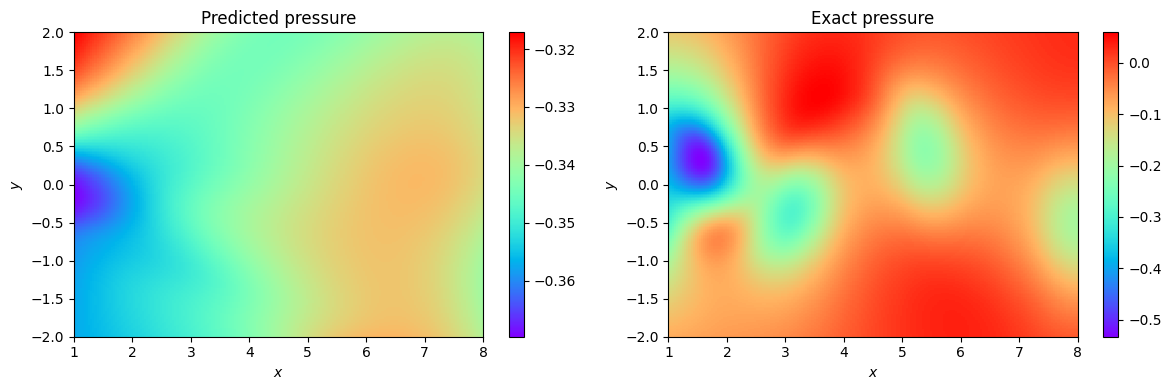

Sauvegardé : pressure_comparison_adam_lbfgs_CNN.png


In [ ]:
# -----------------------------
# MAIN
# -----------------------------
if __name__ == "__main__":

    print("Loading the data...")
    try:
        data = scipy.io.loadmat("/content/cylinder_nektar_wake.mat")
    except FileNotFoundError:
        print("Erreur: /content/cylinder_nektar_wake.mat introuvable.")
        exit()

    U_star = data["U_star"]
    t_star = data["t"]
    X_star = data["X_star"]


    N_val = 2000
    idx = np.random.choice(X_star.shape[0] * t_star.shape[0], N_val, replace=False)

    XX = np.tile(X_star[:, 0:1], (1, t_star.shape[0])).flatten()
    YY = np.tile(X_star[:, 1:2], (1, t_star.shape[0])).flatten()
    TT = np.tile(t_star, (1, X_star.shape[0])).T.flatten()
    UU = U_star[:, 0, :].flatten()
    VV = U_star[:, 1, :].flatten()

    x_val = torch.tensor(XX[idx][:, None], dtype=torch.float32).to(device)
    y_val = torch.tensor(YY[idx][:, None], dtype=torch.float32).to(device)
    t_val = torch.tensor(TT[idx][:, None], dtype=torch.float32).to(device)
    u_val = torch.tensor(UU[idx][:, None], dtype=torch.float32).to(device)
    v_val = torch.tensor(VV[idx][:, None], dtype=torch.float32).to(device)

    xyt_val = torch.cat([x_val, y_val, t_val], dim=1).unsqueeze(-1).unsqueeze(-1)
    xyt_val.requires_grad_(True)
    u_val = u_val.unsqueeze(-1).unsqueeze(-1)
    v_val = v_val.unsqueeze(-1).unsqueeze(-1)

    # ---------------------------------------------------------
    # Generating landscapes
    # ---------------------------------------------------------
    generate_landscape_plot(
        "navier_adam_lbfgs_model_10000.pth",
        "navier_adam_lbfgs_traj_10000.pt",
        "Adam + LBFGS",
        "landscape_adam_lbfgs_10000.png",
        xyt_val,
        u_val,
        v_val,
    )

   # generate_landscape_plot(
     #   "navier_adam_only_model.pth",
      #  "navier_adam_only_traj.pt",
       # "Adam Only",
        #"landscape_adam_only.png",
        #xyt_val,
        #u_val,
        #v_val,
    #)

    #generate_landscape_plot(
     #   "navier_sgd_model.pth",
      #  "navier_sgd_traj.pt",
       # "SGD",
        #"landscape_sgd.png",
        #xyt_val,
        #u_val,
        #v_val,
    #)

    # ---------------------------------------------------------
    # Pressure Graph
    # ---------------------------------------------------------

    plot_pressure_field(
        model_path="navier_adam_lbfgs_model_10000.pth",
        data=data,
        snap_idx=100,
        output_name="pressure_comparison_adam_lbfgs_CNN_10000.png",
    )
